In [2]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import tempfile
import gzip
import pylhe
import math
import csv
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D


pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams['figure.max_open_warning'] = 50
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [2]:
#Extracting the ratio data from csv
ratio_path = 'data/ratioMATRIX_Fig19a.csv'
ratio = pd.read_csv(ratio_path, header = 1)
print(ratio.head())

#Extracting the points of the top of the uncertainty bar
data_2_unc_path = 'data/data_CMS_Unc_mtt.csv'
top_unc_points = pd.read_csv(data_2_unc_path , header = 1)
print(top_unc_points.head())

    mtt [GeV]     Ratio
0  382.284382  0.952113
1  470.862471  1.011268
2  550.116550  1.002817
3  630.303030  1.009390
4  710.489510  1.006573


FileNotFoundError: [Errno 2] No such file or directory: 'data/data_CMS_Unc_mtt.csv'

## Computing the uncerainty of the ratio

Notice that we have the coordinates of the top of the uncertainty bar of the ratio, therefore, the uncertainty itself must be the difference $y_\sigma - y_{ratio}$

In [4]:
ratio_unc = top_unc_points - ratio
print(ratio_unc.head())

      mtt [GeV]     Ratio
0 -9.324009e-01  0.065728
1 -9.324009e-01  0.070423
2 -1.136868e-13  0.070423
3  0.000000e+00  0.077934
4 -9.324009e-01  0.071362


In [8]:
print(csv_reader('data/ratioMATRIX_Fig19a.csv'))

[['# Ratio of SM prediction to data for MATRIX digitized from https://cms-results.web.cern.ch/cms-results/public-results/publications/TOP-20-001/CMS-TOP-20-001_Figure_019-a.png.'], ['mtt [GeV]', ' Ratio'], ['382.2843822843822', ' 0.9521126760563379'], ['470.8624708624709', ' 1.0112676056338028'], ['550.1165501165502', ' 1.0028169014084503'], ['630.3030303030304', ' 1.0093896713615023'], ['710.4895104895105', ' 1.0065727699530516'], ['790.6759906759908', ' 0.9971830985915489'], ['887.6456876456878', ' 1.035680751173709'], ['987.4125874125874', ' 0.9896713615023469'], ['1131.002331002331', ' 1.072300469483568'], ['1282.0512820512822', ' 1.0065727699530516'], ['1475.0582750582753', ' 1.1154929577464787'], ['1674.5920745920746', ' 1.0018779342723003'], ['1961.7715617715621', ' 0.9793427230046936'], ['2262.0046620046624', ' 1.2413145539906107'], ['2562.2377622377626', ' 1.1906103286384975']]


In [3]:
def csv_reader(filename):
    '''
    Read data from a .csv file
    '''
    output = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            output.append(row)
        csvfile.close()

    return output

In [7]:
def get_ratio_err(bg_ratio, bg_ratio_err):
    '''
    Convert the coordinates of the top of the error bar to the actual length of error bar
    '''
    ratio_err = []
    for i,item in enumerate(bg_ratio_err[2:]):
        ratio_err.append(float(item[1]) - float(bg_ratio[i+2][1])) #Compute the length of the upper error bar
    return ratio_err

In [8]:
def get_bg_error(cms_bg, data, bg_ratio_err):
    '''
    Computes the background error from the data and ratio values and errors.
    '''
    bg_err = []
    for i,item in enumerate(data[9:24]):
        data_err = np.sqrt(float(item[4])**2 + float(item[6])**2) #Considering the statistical and systematic errors
        err = (float(item[3])**2 / cms_bg[i]) * np.sqrt(bg_ratio_err[i]**2 + (data_err / float(item[3]))**2) #computing the error
        bg_err.append(err)
    return np.array(bg_err)

In [10]:
def read_CMSdata(dataDir='./data',bg="MATRIX"):
    '''
    Read data and covmat from hepdata. Computes the backgorund and its error from the ratio of the plot.
    '''
    data = csv_reader(os.path.join(dataDir,'parton_abs_ttm.csv'))
    cms_data  = []
    for item in data[9:24]:
        cms_data.append(float(item[3]))

    
    if bg == "MATRIX":
        bg_ratio = csv_reader(os.path.join(dataDir,'ratioMATRIX_Fig19a.csv'))
        bg_ratio_err = csv_reader(os.path.join(dataDir,'err_ratioMATRIX_Fig19a.csv')) #Coordinates of the top of the error bars
        bg_ratio_err = get_ratio_err(bg_ratio, bg_ratio_err) #Convert the coordinates in the error 
    elif bg == "MG5":
        bg_ratio = csv_reader(os.path.join(dataDir,'ratioMGPY8_Fig19a.csv'))
    else:
        print("Only MATRIX and MG5 backgrounds are available")
    cms_bg = []
    for i,item in enumerate(bg_ratio[2:]):
        cms_bg.append(float(item[1])*cms_data[i]) #Multiplying the ratio by the data to obtain MATRIX
    # The digitized values are divided by the width
    #cms_bg = np.array(cms_bg)*bin_widths
    

    covdata = csv_reader(os.path.join(dataDir,'parton_abs_ttm_covariance.csv'))
    covmat = np.zeros(15*15).reshape(15,15)

    covmatlist = []
    count=0
    for item in covdata[9:234]:
        covmatlist.append(float(item[6]))

    for i in range(15):
        for j in range(15):
            covmat[i,j] = covmatlist[count]
            count+=1

    return np.array(cms_data), np.array(cms_bg), np.array(covmat), np.array(cms_bg_err)

## How to compute the MATRIX error

We know that we have:

$$ratio = \frac{MATRIX}{Data}$$

Therefore, the error of the ratio must be:

$$err_{ratio} = \sqrt{\left(\frac{err_D}{Data}\right)^2 + \left(\frac{MATRIX \cdot err_M}{Data^2}\right)^2}$$

In order to get $err_M$, we must invert the equation above:

$$err_M = \frac{Data^2}{MATRIX}\sqrt{err_{ratio}^2 - \left(\frac{err_D}{Data}\right)^2}$$

Notice that we do not need the absolute value since MATRIX is always positive.

In [12]:
a,b,c = read_CMSdata()
print(b)

[3.27717183e-01 8.81521972e-01 5.44329014e-01 3.18260563e-01
 1.82089014e-01 1.09291268e-01 6.47404038e-02 3.65881502e-02
 1.91298404e-02 9.06418779e-03 4.25560563e-03 1.77232207e-03
 6.79761784e-04 2.36470423e-04 3.74685070e-05]


In [15]:
recastData = pd.read_pickle('pp2tt_cms_top_20_001.pcl')
print(recastData)


        model   mPsiT    mSDM     mT  yDM              process  xsec (pb)  \
0  1-loop VLF   500.0   375.0  172.5  1.0  $p p \to t \bar{t}$   0.211590   
1  1-loop VLF   500.0   475.0  172.5  1.0  $p p \to t \bar{t}$   0.180120   
2  1-loop VLF   600.0   475.0  172.5  1.0  $p p \to t \bar{t}$   0.132150   
3  1-loop VLF  1500.0  1425.0  172.5  1.0  $p p \to t \bar{t}$   0.015886   

   MC Events                                               file  bin_250_400  \
0    2988815  /home/vinicius/EFT_ToyModel/processFolders/Dis...     0.036696   
1    1689648  /home/vinicius/EFT_ToyModel/processFolders/Dis...     0.031224   
2    4777529  /home/vinicius/EFT_ToyModel/processFolders/Dis...     0.023932   
3    1162955  /home/vinicius/EFT_ToyModel/processFolders/Dis...     0.003215   

   ...  bin_1300_1500  bin_1300_1500_Error  bin_1500_1700  \
0  ...       0.000772             0.000004      -0.000106   
1  ...       0.000791             0.000005      -0.000014   
2  ...       0.002097         

In [16]:
recastData = pd.read_pickle('limits_cms_top_20_001.pcl')
print(recastData)

        model   mPsiT    mSDM     mT  yDM              process  xsec (pb)  \
0  1-loop VLF   500.0   375.0  172.5  1.0  $p p \to t \bar{t}$   0.211590   
1  1-loop VLF   500.0   475.0  172.5  1.0  $p p \to t \bar{t}$   0.180120   
2  1-loop VLF   600.0   475.0  172.5  1.0  $p p \to t \bar{t}$   0.132150   
3  1-loop VLF  1500.0  1425.0  172.5  1.0  $p p \to t \bar{t}$   0.015886   

   MC Events                                               file  bin_250_400  \
0    2988815  /home/vinicius/EFT_ToyModel/processFolders/Dis...     0.036696   
1    1689648  /home/vinicius/EFT_ToyModel/processFolders/Dis...     0.031224   
2    4777529  /home/vinicius/EFT_ToyModel/processFolders/Dis...     0.023932   
3    1162955  /home/vinicius/EFT_ToyModel/processFolders/Dis...     0.003215   

   ...  bin_1500_1700_Error  bin_1700_2000  bin_1700_2000_Error  \
0  ...         1.371326e-06      -0.000286         1.023063e-06   
1  ...         9.486025e-07      -0.000198         8.045430e-07   
2  ...      

In [11]:
def csv_reader(filename):
    output = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            output.append(row)
        csvfile.close()

    return output

def get_ratio_err(bg_ratio, bg_ratio_err):
    '''
    Convert the coordinates of the top of the error bar to the actual length of error bar
    '''
    ratio_err = []
    for i,item in enumerate(bg_ratio_err[2:]):
        ratio_err.append(float(item[1]) - float(bg_ratio[i+2][1])) #Compute the length of the upper error bar
    return ratio_err

def get_bg_error(cms_bg, data, bg_ratio_err):
    '''
    Computes the background error from the data and ratio values and errors.
    '''
    bg_err = []
    for i,item in enumerate(data[9:24]):
        data_err = np.sqrt(float(item[4])**2 + float(item[6])**2) #Considering the statistical and systematic errors
        err = (float(item[3])**2 / cms_bg[i]) * np.sqrt(bg_ratio_err[i]**2 + (data_err / float(item[3]))**2) #computing the error
        bg_err.append(err)
    return np.array(bg_err)

def read_CMSdata(dataDir='./data',bg="MATRIX"):
    '''
    Read data and covmat from hepdata. Computes the backgorund and its error from the ratio of the plot.
    '''
    data = csv_reader(os.path.join(dataDir,'parton_abs_ttm.csv'))
    cms_data  = []
    for item in data[9:24]:
        cms_data.append(float(item[3]))

    
    if bg == "MATRIX":
        bg_ratio = csv_reader(os.path.join(dataDir,'ratioMATRIX_Fig19a.csv'))
        bg_ratio_err = csv_reader(os.path.join(dataDir,'err_ratioMATRIX_Fig19a.csv')) #Coordinates of the top of the error bars
        bg_ratio_err = get_ratio_err(bg_ratio, bg_ratio_err) #Convert the coordinates in the error 
    elif bg == "MG5":
        bg_ratio = csv_reader(os.path.join(dataDir,'ratioMGPY8_Fig19a.csv'))
    else:
        print("Only MATRIX and MG5 backgrounds are available")
    cms_bg = []
    for i,item in enumerate(bg_ratio[2:]):
        cms_bg.append(float(item[1])*cms_data[i]) #Multiplying the ratio by the data to obtain MATRIX
    # The digitized values are divided by the width
    #cms_bg = np.array(cms_bg)*bin_widths
    
    cms_bg_err = get_bg_error(cms_bg, data, bg_ratio_err)

    covdata = csv_reader(os.path.join(dataDir,'parton_abs_ttm_covariance.csv'))
    covmat = np.zeros(15*15).reshape(15,15)

    covmatlist = []
    count=0
    for item in covdata[9:234]:
        covmatlist.append(float(item[6]))

    for i in range(15):
        for j in range(15):
            covmat[i,j] = covmatlist[count]
            count+=1

    return np.array(cms_data), np.array(cms_bg), np.array(covmat), np.array(cms_bg_err)

In [8]:
def plot_limit_comparison(pickle_file, data_dir='./data'):
    
    # A. Load CMS Data, Background, and Covariance
    # obs_data: The observed dSigma/dm
    # sm_bg: The Standard Model prediction dSigma/dm
    # cov_mat: The covariance matrix of the data
    obs_data, sm_bg, cov_mat, sm_bg_err = read_CMSdata(data_dir)
    
    # Calculate Data Error from Covariance Matrix (Diagonal elements)
    # Uncertainty = sqrt(Variance)
    obs_err = np.sqrt(np.diag(cov_mat))
    
    # B. Load Signal Data
    try:
        recast_df = pd.read_pickle('limits_cms_top_20_001.pcl')
    except FileNotFoundError:
        print("Pickle file not found.")
        return

<>:136: SyntaxWarning: invalid escape sequence '\p'
<>:136: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_24634/167572669.py:136: SyntaxWarning: invalid escape sequence '\p'
  mass_label = f"$m_{{\psi_T}}={mPsiT_val}$ GeV, $m_s={mSDM_val}$ GeV"


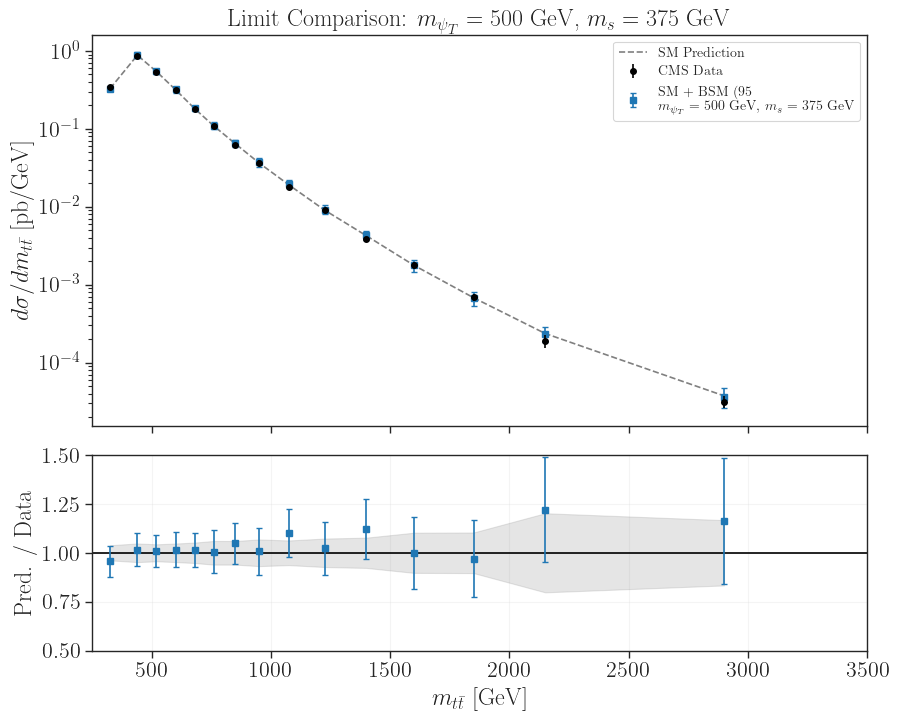

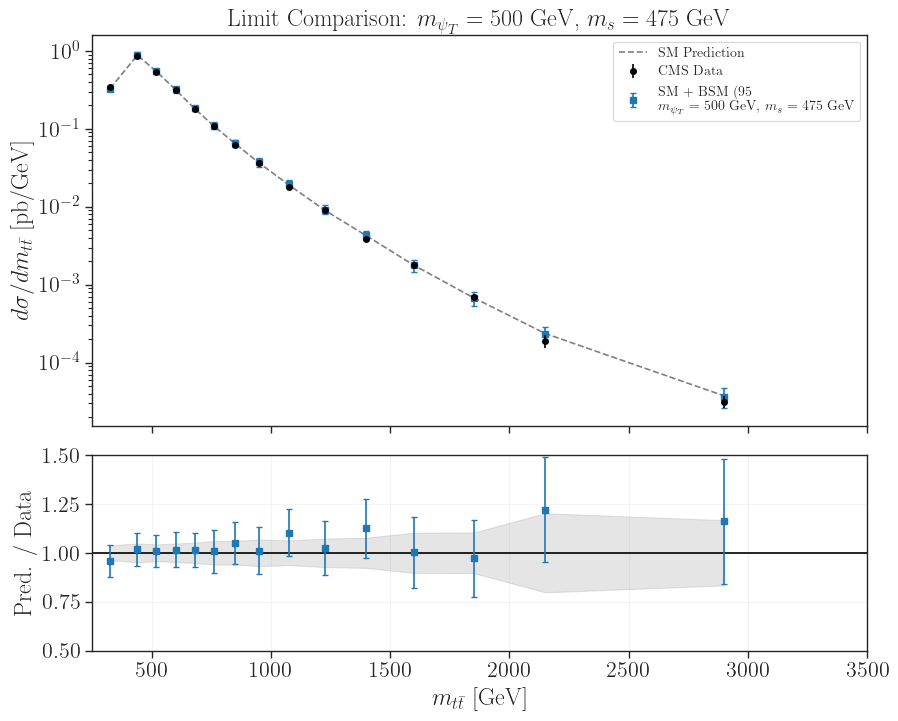

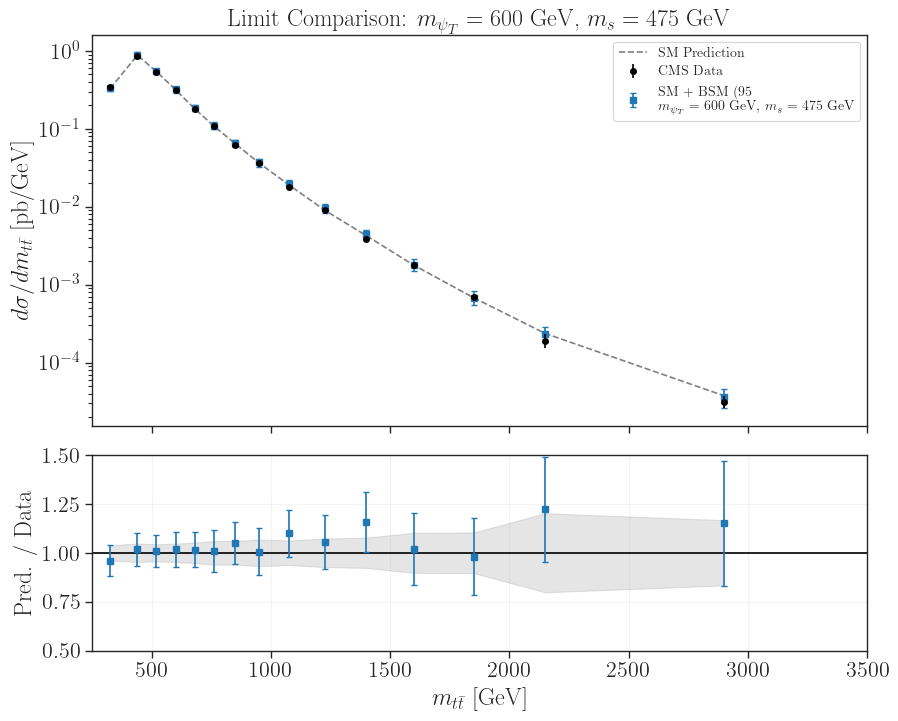

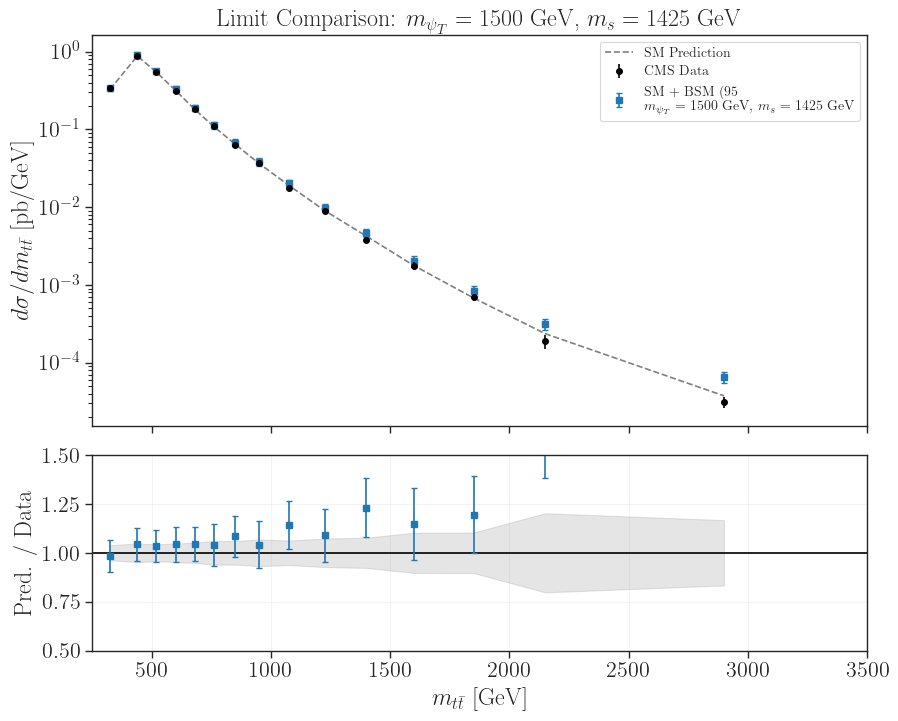

In [25]:

cms_bins = np.array([250.,400.,480.,560.,640.,720.,800.,900.,1000.,
                1150.,1300.,1500.,1700.,2000.,2300.,3500.])
bin_widths = cms_bins[1:] - cms_bins[:-1]
bin_centers = (cms_bins[:-1] + cms_bins[1:]) / 2.0


def csv_reader(filename):
    output = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            output.append(row)
    return output

def get_ratio_err(bg_ratio, bg_ratio_err):
    ratio_err = []
    for i,item in enumerate(bg_ratio_err[2:]):
        ratio_err.append(float(item[1]) - float(bg_ratio[i+2][1])) 
    return ratio_err

def get_bg_error(cms_bg, data, bg_ratio_err):
    bg_err = []
    for i,item in enumerate(data[9:24]):
        data_err = np.sqrt(float(item[4])**2 + float(item[6])**2) 
        err = (float(item[3])**2 / cms_bg[i]) * np.sqrt(bg_ratio_err[i]**2 + (data_err / float(item[3]))**2) 
        bg_err.append(err)
    return np.array(bg_err)

def read_CMSdata(dataDir='./data', bg="MATRIX"):
    if not os.path.exists(dataDir):
        print(f"Error: Data directory '{dataDir}' not found.")
        return None, None, None, None

    data = csv_reader(os.path.join(dataDir,'parton_abs_ttm.csv'))
    cms_data  = []
    for item in data[9:24]:
        cms_data.append(float(item[3]))
    
    if bg == "MATRIX":
        bg_ratio = csv_reader(os.path.join(dataDir,'ratioMATRIX_Fig19a.csv'))
        bg_ratio_err = csv_reader(os.path.join(dataDir,'err_ratioMATRIX_Fig19a.csv')) 
        bg_ratio_err = get_ratio_err(bg_ratio, bg_ratio_err) 
    elif bg == "MG5":
        bg_ratio = csv_reader(os.path.join(dataDir,'ratioMGPY8_Fig19a.csv'))
    else:
        print("Only MATRIX and MG5 backgrounds are available")
        return None, None, None, None

    cms_bg = []
    for i,item in enumerate(bg_ratio[2:]):
        cms_bg.append(float(item[1])*cms_data[i]) 
    
    cms_bg_err = get_bg_error(cms_bg, data, bg_ratio_err)

    covdata = csv_reader(os.path.join(dataDir,'parton_abs_ttm_covariance.csv'))
    covmat = np.zeros(15*15).reshape(15,15)

    covmatlist = []
    count=0
    for item in covdata[9:234]:
        covmatlist.append(float(item[6]))

    for i in range(15):
        for j in range(15):
            covmat[i,j] = covmatlist[count]
            count+=1

    return np.array(cms_data), np.array(cms_bg), np.array(covmat), np.array(cms_bg_err)



def plot_limit_comparison(pickle_file, data_dir='./data'):
    
    
    obs_data, sm_bg, cov_mat, sm_bg_err = read_CMSdata(data_dir)
    
    if obs_data is None:
        return

    # Calculate Data Error from Covariance Matrix
    obs_err = np.sqrt(np.diag(cov_mat))
    
    
    try:
        recast_df = pd.read_pickle(pickle_file)
    except FileNotFoundError:
        print(f"Pickle file '{pickle_file}' not found.")
        return

    
    for idx, row in recast_df.iterrows():
        
        
        fig, axarr = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [2, 1]}, figsize=(10, 8))
        plt.subplots_adjust(hspace=0.1)

        
        raw_signal = []
        raw_signal_err = [] 
        
        for i in range(len(cms_bins)-1):
            col_name = f"bin_{int(cms_bins[i])}_{int(cms_bins[i+1])}"
            err_col_name = col_name + "_Error"
            
            if col_name in row:
                raw_signal.append(row[col_name])
                raw_signal_err.append(row.get(err_col_name, 0.0)) 
            else:
                raw_signal.append(0.0)
                raw_signal_err.append(0.0)

        raw_signal = np.array(raw_signal)
        raw_signal_err = np.array(raw_signal_err)

        # Normalize Signal and Error
        gen_yDM = row['yDM']
        signal_density = (raw_signal / (gen_yDM**2)) / bin_widths
        signal_density_err = (raw_signal_err / (gen_yDM**2)) / bin_widths
        
        # Get 95% Limit Coupling
        yDM_95 = row.get('yDM (95% C.L.)', 1.0)
        scale_factor = yDM_95**2
            
        # Calculate Total Theory and Total Error
        signal_95 = signal_density * scale_factor
        signal_95_err = signal_density_err * scale_factor 
        
        total_theory = sm_bg + signal_95
        # Combine errors in quadrature
        total_theory_err = np.sqrt(sm_bg_err**2 + signal_95_err**2)
        
        # --- PLOTTING ---
        
        mPsiT_val = int(row['mPsiT'])
        mSDM_val = int(row['mSDM'])
        mass_label = f"$m_{{\psi_T}}={mPsiT_val}$ GeV, $m_s={mSDM_val}$ GeV"
        

        # Plot Data
        axarr[0].errorbar(bin_centers, obs_data, yerr=obs_err, fmt='o', color='black', 
                          label='CMS Data', zorder=10, markersize=4)
        # Plot SM Background
        axarr[0].plot(bin_centers, sm_bg, color='gray', linestyle='--', label='SM Prediction')
        
        line_color = 'tab:blue' 
        axarr[0].errorbar(bin_centers, total_theory, yerr=total_theory_err, 
                          fmt='s', color=line_color, markersize=4, capsize=2,
                          label=f'SM + BSM (95% CL)\n{mass_label}')
        
       
        
        
        rel_obs_err = obs_err / obs_data
        axarr[1].axhline(1.0, color='black', linestyle='-')
        # Shaded Band for Data Uncertainty
        axarr[1].fill_between(bin_centers, 1.0 - rel_obs_err, 1.0 + rel_obs_err,
                              color='gray', alpha=0.2, label='Data Uncert.')

        #Total Theory / Data
        ratio_theory = total_theory / obs_data
        
        # Error on ratio: relative theory uncertainty relative to data
        ratio_theory_err = total_theory_err / obs_data
        
        # Plot Ratio with Error Bar
        axarr[1].errorbar(bin_centers, ratio_theory, yerr=ratio_theory_err,
                          fmt='s', color=line_color, markersize=4, capsize=2)

        axarr[0].set_yscale('log')
        axarr[0].set_ylabel(r'$d\sigma / dm_{t\bar{t}}$ [pb/GeV]')
        axarr[0].set_xlim(cms_bins[0], cms_bins[-1])
        axarr[0].legend(loc='upper right', fontsize=10)
        axarr[0].set_title(f"Limit Comparison: {mass_label}")
        
        axarr[1].set_ylabel('Pred. / Data')
        axarr[1].set_xlabel(r'$m_{t\bar{t}}$ [GeV]')
        axarr[1].set_ylim(0.5, 1.5) 
        axarr[1].grid(True, which="both", ls="-", alpha=0.2)
        
        plt.show()


pickle_file_path = 'limits_cms_top_20_001.pcl' 
plot_limit_comparison(pickle_file_path)